#### In this notebook:  
* we cross-validate Gamma Ray carotage models on 4 wells from the Netherlands Offshore F3 Block open project, https://terranubis.com/datainfo/Netherlands-Offshore-F3-Block-Complete  
* Dictionary `weights` provides list of 4 models ordered according to test folds. Every test fold associated with just one well -  F02-1, F03-2, F03-4, F06-1. Each of the wells is projected onto 42 nearest seismic slices (2 inlines/crosslines x 21 slices) 
* we average well carotage across multiple slices and calculate statistics  
* we visualize predictions: carotage for a single well and carotage for a whole seismic slice   

### Download the dataset

In [1]:
! sh ../src/download_data.sh

--2020-06-28 21:56:38--  http://data.neu.ro/ml-recipe-seismic.zip
Resolving data.neu.ro (data.neu.ro)... 52.216.88.170
Connecting to data.neu.ro (data.neu.ro)|52.216.88.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 871049433 (831M) [application/zip]
Saving to: ‘/tmp/tmp.ftin93qXgw/ml-recipe-seismic.zip’

/tmp/tmp.ftin93qXgw 100%[===================>] 830.70M  92.7MB/s    in 9.2s    

2020-06-28 21:56:48 (89.9 MB/s) - ‘/tmp/tmp.ftin93qXgw/ml-recipe-seismic.zip’ saved [871049433/871049433]

Archive:  /tmp/tmp.ftin93qXgw/ml-recipe-seismic.zip
  inflating: /storage_path/data/wellheads.csv  
  inflating: /storage_path/data/las/raw/F02-1.log.csv  
  inflating: /storage_path/data/las/raw/F03-2.log.csv  
  inflating: /storage_path/data/las/raw/F03-4.log.csv  
  inflating: /storage_path/data/las/raw/F06-1.log.csv  
  inflating: /storage_path/data/las/smoothed/F02-1.log.csv  
  inflating: /storage_path/data/las/smoothed/F03-2.log.csv  
  inflating: /storage_path/da

In [11]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

# make user code available:
import sys
from pathlib import Path
module_path = Path('.').absolute().parent
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path / 'src'))

from const import (
    model_dir, # path to models
    wells,  # well names
    ilines, xlines, nsamples, dt, # seismic cube parameters
    slices_dir, crossval_dict
)
from predict import (
    predict_on_fold,
    eval_fold,
    process_all_folds,
    average_prediction,
)
from train import get_train_test_split
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# trained models in the order of cv test folds
weights = {
    'Gamma_Ray': [
        'uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_1.11-0.37.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_2.07-0.65.hdf5',
        'uResNet34.Gamma_Ray.sz480x512.smtd_3.42-0.67.hdf5'
    ],
}

### Evaluate models for Gamma Ray carotage

In [4]:
carotage = 'Gamma_Ray'
eval_dict = process_all_folds(weights, carotage)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Load weights from /storage_path/models/smoothed/uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5


[Run:AI] [DEBUG   ] [28-06-2020 21:57:14.401] [199] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

fold: 0 corr: 0.8143997107029263
Load weights from /storage_path/models/smoothed/uResNet34.Gamma_Ray.sz480x512.smtd_1.11-0.37.hdf5


[Run:AI] [DEBUG   ] [28-06-2020 21:57:34.128] [199] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 1 corr: 0.4712236456398965
Load weights from /storage_path/models/smoothed/uResNet34.Gamma_Ray.sz480x512.smtd_2.07-0.65.hdf5


[Run:AI] [DEBUG   ] [28-06-2020 21:57:51.046] [199] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 2 corr: 0.6847286585265939
Load weights from /storage_path/models/smoothed/uResNet34.Gamma_Ray.sz480x512.smtd_3.42-0.67.hdf5


[Run:AI] [DEBUG   ] [28-06-2020 21:58:07.850] [199] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


fold: 3 corr: 0.7354877391424987


#### Average predicted carotage for a well across all slices associated with this well

In [5]:
mean_eval_dict = average_prediction(eval_dict)
all_correlations = [v['corr'] for v in mean_eval_dict.values()]
print(f'\nOverall correlation: {np.mean(all_correlations):0.2f}')

well F02-1, corr=0.88
well F03-2, corr=0.70
well F03-4, corr=0.82
well F06-1, corr=0.81

Overall correlation: 0.80


### Visualize

#### Prediction distribution across all slices

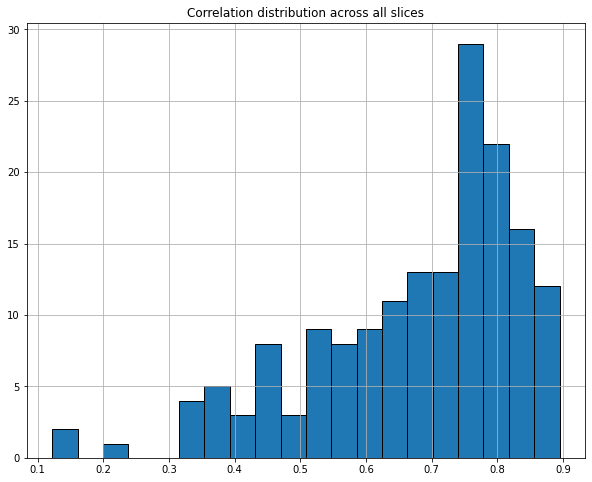

In [6]:
correlations = [v['corr'] for v in eval_dict.values()]
fig = plt.figure(figsize=(10, 8))
plt.hist(correlations, bins=20, edgecolor='black', linewidth=1.0)
plt.grid('on')
plt.title('Correlation distribution across all slices')
plt.show()

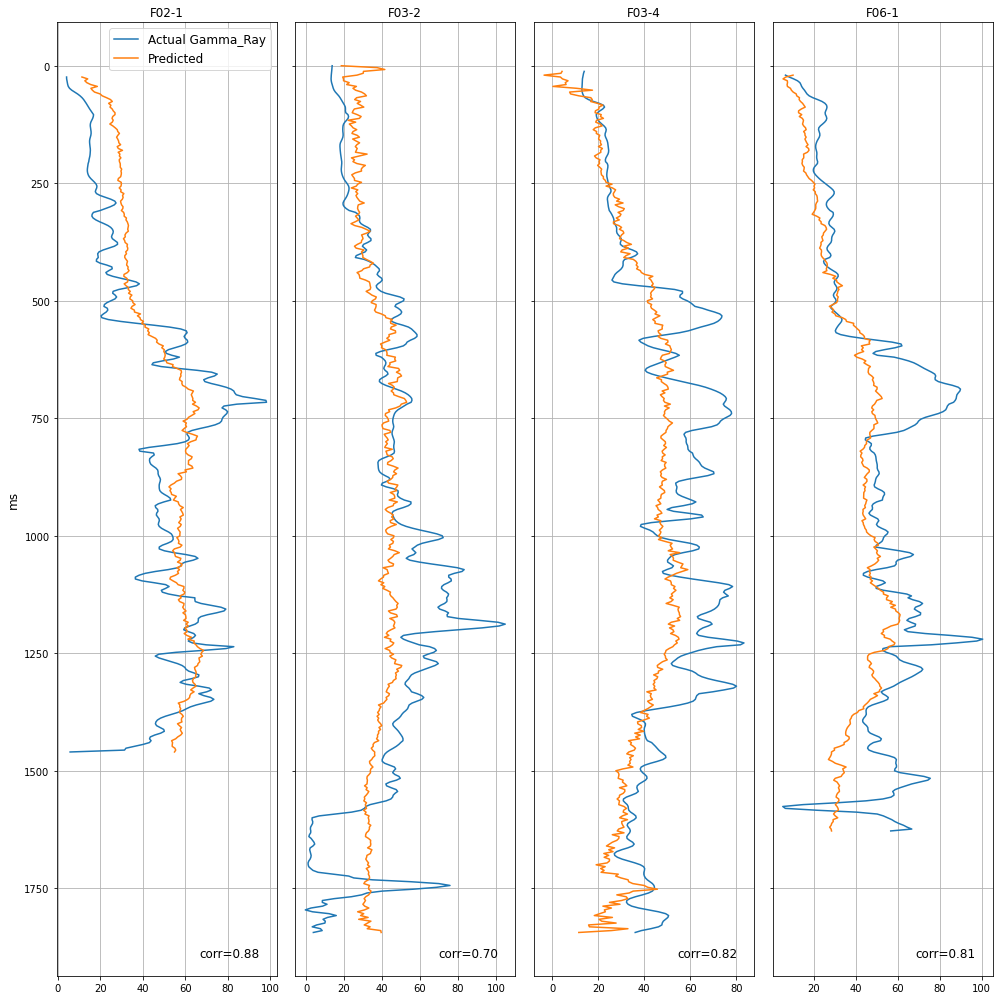

In [7]:
fontsize = 12
fig, ax = plt.subplots(1, 4, figsize=(14, 14), sharey=True)

for i, (w, ax_) in enumerate(zip(wells, ax.flatten())):
    t = mean_eval_dict[w]['t']
    true_carotage = mean_eval_dict[w]['true_carotage']
    pred_carotage = mean_eval_dict[w]['pred_carotage']
    corr = mean_eval_dict[w]['corr']
    ax_.plot(true_carotage, t, pred_carotage, t)
    ax_.set_title(f'{w}', fontsize=fontsize)
    if i == 0:
        ax_.set_ylabel('ms', fontsize=fontsize)
        ax_.legend([f'Actual {carotage}', 'Predicted'], fontsize=fontsize)
    ax_.text(0.65, 0.02, f'corr={corr:0.2f}', transform=ax_.transAxes, fontsize=fontsize)
    ax_.grid(True)
ax_.invert_yaxis()    
    
plt.tight_layout()
plt.show()

### Visualize predicted Gamma Ray carotage for a whole seismic slice  
#### well F02-1 is associated with test fold 0 and projected onto 42 nearest seismic slices; one of them - inline 363

In [12]:
fold = 0
cv_dataset = get_train_test_split(slices_dir, crossval_dict)
slice_list = cv_dataset[fold]['test']
carotage = 'Gamma_Ray'
data = predict_on_fold(slice_list, carotage, model_dir / weights[carotage][fold], verbose=False)

Load weights from /storage_path/models/smoothed/uResNet34.Gamma_Ray.sz480x512.smtd_0.14-0.78.hdf5


[Run:AI] [DEBUG   ] [28-06-2020 22:01:32.099] [199] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


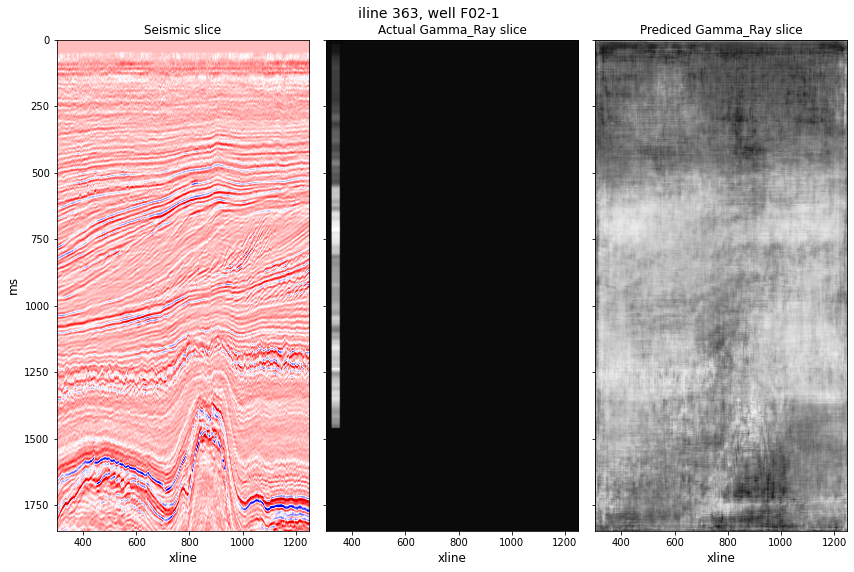

In [13]:
i_d = 'iline_363_F02-1'

color_norm = colors.Normalize(vmin=data[i_d]['y_pred'].min(), vmax=data[i_d]['y_pred'].max())
extent = [min(ilines), max(ilines), nsamples * dt - 1, 0] if 'xline' in i_d else [min(xlines), max(xlines), nsamples * dt - 1, 0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
ax1.imshow(data[i_d]['seism'], cmap='seismic', extent=extent)
ax1.set_title('Seismic slice')
ax1.set_ylabel('ms', fontsize=fontsize)
ax1.set_xlabel('iline' if 'xline' in i_d else 'xline', fontsize=fontsize)

ax2.imshow(data[i_d]['y_true'], cmap='Greys_r', extent=extent, norm=color_norm)
ax2.set_title(f'Actual {carotage} slice')
ax2.set_xlabel('iline' if 'xline' in i_d else 'xline', fontsize=fontsize)

ax3.imshow(data[i_d]['y_pred'], cmap='Greys_r', extent=extent, norm=color_norm)
ax3.set_title(f'Prediced {carotage} slice')
ax3.set_xlabel('iline' if 'xline' in i_d else 'xline', fontsize=fontsize)

plt.tight_layout()
plt.suptitle(f'{{}} {{}}, well {{}}'.format(*i_d.split('_')), fontsize=14, y=0.99)
plt.show()